In [654]:
# Python built-in library imports
import os
from collections import OrderedDict

# pip installed library imports
import h5py
import matplotlib.cm as cm
import matplotlib.colors
import matplotlib.patches as mpatches

import matplotlib.pyplot as plt
import netCDF4
import numpy as np
import pandas as pd
import scipy as sci

import mpl_toolkits
from mpl_toolkits.basemap import Basemap

# Objective:

1. To calculate global average per year

### Utility tools

In [584]:
utils = {
    'map_title': 'Monthly Averaged Methane Column Mixing Ratio (20{})',
    'data_dir': './data/SWIRL3CH4/all_data/SWIRL3CH4/',  
    'data_loc': '/Users/mlimb/sio/methane/gosat/data/SWIRL3CH4/all_data/SWIRL3CH4/{}',
}


### Intialize `aliso_trend` dictionary

Notes

- OrderedDict has year [int] as keys from 2009 to 2017
- aliso_trend[year] has an list of 12 elements
- each element is initialized to null value of **-1** 

#### **<span style="color:orange; background-color: navy">Question</span>**

- Is **-1** a good choice of null value?

In [585]:
all_years = range(2009, 2017+1)

# initialize OrderedDict with year [int] mapping to empty list []
# using -1 as init
aliso_trend = OrderedDict((year,[-1]*12) for year in all_years)

# manual chek
# for k,v in aliso_trend.items():
#     print k # should year year [int] 2009 to 2017
#     print v # should be []

In [586]:
data_dir = utils['data_dir']
data_loc = utils['data_loc']
len(os.listdir(data_dir))

89

In [587]:
files = [f for f in os.listdir(data_dir) if f.endswith('.h5')]
len(files)

89

In [588]:
# dictionary that maps month number to names (Long version, 3-letter abbreviated version,
# month number as int).
# all in Strings
month_names = {
    '01': ('January', 'JAN', 1),
    '02': ('February', 'FEB', 2),
    '03': ('March', 'MAR', 3),
    '04': ('April', 'APR', 4),
    '05': ('May', 'MAY', 5),
    '06': ('June', 'JUN', 6),
    '07': ('July', 'JUL', 7),
    '08': ('August', 'AUG', 8),
    '09': ('September', 'SEP', 9),
    '10': ('October', 'OCT', 10),
    '11': ('November', 'NOV', 11),
    '12': ('December', 'DEC', 12)
}



I manually confirmed all filenames.

**All available data**<br />
2009 June to 2017 February EXCEPT:

Known missing data<br />
- 2014 June and December 
- 2015 January and September 

Q. Why is there no data after 2017 FEB?

## Write out what to do

I have a list of files that have global coverage, 
one monthly average per file

From each of the 89 matrix, I only need a single value,
the one nearest to the Aliso Canyon Oil Field

    this is at: 
        [lon, lat] = -118.75, 33.75

    which is same as location as:
        ???
    
Given:
- 2.5 degrees lat/lon spatial resolution
- starting values hidden in the h5 file

`get_aliso_value` (function): given the point, get value at that exact point for all years

<hr >
**Tasks:**

1) Open files **<span style="color:black; background-color: yellow">DONE</span>**

- Loop through all files, open all, save netcdf of all **<span style="color:black; background-color: yellow">DONE</span>**
- Mask the files **<span style="color:black; background-color: yellow">DONE</span>**

2) Determine the location for the Aliso lon/lat combo **<span style="color:red; background-color: black">Don't Panic</span>**

- What is the lon/lat value nearest to the Aliso Canyon Oil Field? **<span style="color:black; background-color: yellow">DONE</span>**

        34.3122, -118.5645 (from USGS data)

- What is the matrix [x,y] of the [lon, lat]? **<span style="color:black; background-color: yellow">DONE</span>**

        Latitude: lats[22][0] (33.75)
        Longitude: lons[0][24] (-118.75)


- Write a function that retrieves the value at [x,y] for each matrix **<span style="color:black; background-color: yellow">DONE</span>**


3) Write `get_aliso_value` function: **<span style="color:black; background-color: yellow">DONE</span>**

- Add 1 value to aliso_trend as looping over** 

Either 
- given the point, get value at that exact point for all years
- OR given the global monthly data and one point, return the methane value at that point

4) Create an OrderedDictionary of years to store all data per month by year **<span style="color:black; background-color: yellow">DONE</span>**

5) Manual confirmation that point is accurate** **<span style="color:black; background-color: lightgreen">In Progress</span>**


missing value (invalid) is `-9999.99`
```
aliso_trend = 
{
    2009: [] # 12 values per yer
    2010: [] 
    2011: []
    2012
    2013
    2014
    2015
    2016
    2017: []
}
```

Need to be 100% correct:
- correct matrix location for lon/lat pair

Status Indicators:
**<span style="color:black; background-color: yellow">DONE</span>**
**<span style="color:black; background-color: lightgreen">In Progress</span>**
**<span style="color:red; background-color: black">Don't Panic</span>**

### Function to retrieve month-year from file name

In [589]:
test = files[0]
year_month = test[9:15]

month = test[13:15]
year = test[9:13]
print month, year

get_year_month = lambda fname: fname[9:15]
get_year_month_tup = lambda year_month_str: (int(year_month_str[0:  4]), month_names.get(year_month_str[4:]))

int(get_year_month(test))

06 2009


200906

In [590]:
# check file string names
files[1:3]

['GOSATTFTS2009070120090731_03C02SV0221.h5',
 'GOSATTFTS2009080120090831_03C02SV0221.h5']

### Store h5 data as netCDF in `ncs` OrderedDict

string year-month (ex. `200906`) is used a key

### **<span style="color:yellow; background-color: darkblue">Added empty string for 4 missing months here</span>**

Having added empty list for invalid data is causing trouble for masked np array calculations

TODO:
**update [] to np.empty([72, 144], dtype=int) then mask it**

In [591]:
# initialize empty OrderedDict
ncs = OrderedDict()

for fname in files:
    year_month = get_year_month(fname)
    ncs[year_month] = netCDF4.Dataset(data_loc.format(fname))
    # manual insertion of missing data as empty arrays (Better here than later due to use
    # or OrderedDicts that doesn't allow inserting element at specified locations)
    if year_month == '201405':
        ncs['201406'] = []
    if year_month == '201411': #consecutive
        ncs['201412'] = []
        ncs['201501'] = []
    if year_month == '201508':
        ncs['201509'] = []

## Essentiall create 72 by 144 completely masked array

In [717]:
# np.ma.array([1, 2, 3], mask = [1]*3)

masked_array(data = [-- -- --],
             mask = [ True  True  True],
       fill_value = 999999)

In [727]:
# initialize empty OrderedDict
ncs2 = OrderedDict()

for fname in files:
    year_month = get_year_month(fname)
    ncs2[year_month] = netCDF4.Dataset(data_loc.format(fname))
    # manual insertion of missing data as empty arrays (Better here than later due to use
    # or OrderedDicts that doesn't allow inserting element at specified locations)
#     if year_month == '201405':
#         ncs2['201406'] = nnp.empty([72, 144], dtype=float)
#     if year_month == '201411': #consecutive
#         ncs2['201412'] = np.empty([72, 144], dtype=float)
#         ncs2['201501'] = np.empty([72, 144], dtype=float)
#     if year_month == '201508':
#         ncs2['201509'] = np.empty([72, 144], dtype=float)

### Check that 4 missing date-month pairs were corrected

In [592]:
print (len(ncs.keys()) - len(files)) is 4

True


In [593]:
# ncs.keys() # manual check

In [594]:
# check keys output
# ncs.keys()

In [595]:
ncs['200910']

<type 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): 
    variables(dimensions): 
    groups: Attribute, Data, Global

In [596]:
def get_ch4_masked_data(nc):
    """Return the *masked* monthly methane average column mixing ratio values
    
    *This is what should be used to generate figures as invalid values will be masked
    and automatically NOT Plotted
    """
    if nc == []:
        return []
    ch4 = nc.groups['Data']['mixingRatio']['XCH4']
    masked_data = np.ma.masked_equal(ch4, value=ch4.invalidValue)
#   print masked_data
    return masked_data

In [597]:
# ncs

In [598]:
# init emtpy ordered dicts
data = OrderedDict()

def make_data_dict(_ncs, _data=OrderedDict()):  
    """Populate the given OrderedDict with given hdf5 data
    Note: If no OrderedDict is given, create an empty one
    
    Result:
        OrderedDict will have these keys: `masked_data` and `flat_data`
        
    * Currently, *masked_data* is used to generate all the maps
    * flat_data is 1D version of 2D arrays and is used to generate histograms
    """
    for key, _nc in _ncs.items():
        _data[key] = {}
        _data[key]['masked_data'] = get_ch4_masked_data(_nc) # used to make maps
#         _data[key]['flat_data'] = _data[key]['data'].flatten() # used to make histograms
    #return _data # commenting this line prevents output

In [599]:
make_data_dict(ncs, data)

In [728]:
data2 = OrderedDict()

In [734]:
make_data_dict(ncs2, data2)
# data2.keys() # missing four values but doesn't matter anyways for masked array op

In [726]:
# a = data['200906']['masked_data']


0.24529727888695985

## don't forget!

data is at `data['200906']['masked_data']`

or more generally `data['yyyymm']['masked_data']

In [601]:
len(data)

93

### GET lat and lon matrices (in 'geolocation') 

In [602]:
geo = ncs['200910']['Data']['geolocation']
geo.variables.keys()
lat =geo.variables.get('latitude')
lon =geo.variables.get('longitude')
lat.shape

(72, 144)

#### Searching for numLatitude and intervalLengthOfLatitude (+ longitude equivalents) in nc

In [603]:
nc = ncs['200910']
ncattrs = nc.groups.get('Attribute')
ncattrs.variables.keys()

[u'intervalLengthOfLatitude',
 u'intevalLengthOfLongitude',
 u'numLatitude',
 u'numLongitude']

In [604]:
aa = [v for k, v in ncattrs.variables.iteritems()]
v = aa[0]
v[0]

aa[3][0]

144

In [605]:
ll = nc.groups.get('Data')['geolocation']['latitude']
ll.ncattrs()

[u'unit', u'validRange', u'longName', u'invalidValue']

#### Covert lats and lons to numpy arrays (right now netCDF.Variable)

In [606]:
lats = np.array(lat)
lons = np.array(lon)

In [607]:
lats

array([[ 88.75,  88.75,  88.75, ...,  88.75,  88.75,  88.75],
       [ 86.25,  86.25,  86.25, ...,  86.25,  86.25,  86.25],
       [ 83.75,  83.75,  83.75, ...,  83.75,  83.75,  83.75],
       ..., 
       [-83.75, -83.75, -83.75, ..., -83.75, -83.75, -83.75],
       [-86.25, -86.25, -86.25, ..., -86.25, -86.25, -86.25],
       [-88.75, -88.75, -88.75, ..., -88.75, -88.75, -88.75]], dtype=float32)

In [608]:
lons

array([[-178.75, -176.25, -173.75, ...,  173.75,  176.25,  178.75],
       [-178.75, -176.25, -173.75, ...,  173.75,  176.25,  178.75],
       [-178.75, -176.25, -173.75, ...,  173.75,  176.25,  178.75],
       ..., 
       [-178.75, -176.25, -173.75, ...,  173.75,  176.25,  178.75],
       [-178.75, -176.25, -173.75, ...,  173.75,  176.25,  178.75],
       [-178.75, -176.25, -173.75, ...,  173.75,  176.25,  178.75]], dtype=float32)

## Calculate and plot global average per year (eventually make this a fn)

1. sum all month matrices for each year

2. one gigantic matrix per year (need to keep track of valid and invalid numbers for division)
3. average per year (make sure to divide by only valid_num) -> use numpy `mean()`
4. plot timeseries

### 2 and 3 -> numpy masked array took care of this. no need to keep track of invalid numbers

Good reference: (https://stackoverflow.com/questions/26931318/averaging-multiple-masked-numpy-arrays-in-python)

In [745]:
# Init OrderedDict with empty lists
data_per_year = OrderedDict((year, []) for year in all_years)
# print data_per_year

# Init OrderedDict with invalid -1 
global_annual_mean = OrderedDict((year, -1) for year in all_years)
# print global_avg_per_year

# all_years include up to 2017
# years exclude 2017

# Constructs data_per_year that maps
# year (int) to a list of masked_data 2-d numpy arrays for all
# available months in that year
for key, _month_data in data2.iteritems():
    (year, month_info) = get_year_month_tup(key)
    (m_name, m_abbr, m_num) = month_info
    data_per_year[year].append(_month_data['masked_data'])

# NOW: Calculate mean of all masked 2-d numpy arrays per year
# should result in single value per year
# np.ma.array((a, b, c)).mean(axis=0)

# I am the global annual means
for year, data_ls in data_per_year.items():
#     for d in data_ls:
#         print d.shape # was causing error due to use of [] for missing months now excluded
    annual_mean_matrix = np.ma.array((data_ls)).mean(axis=0)
    global_annual_mean[year]= annual_mean_matrix.mean()

global_annual_mean

OrderedDict([(2009, 1.7631361649328829),
             (2010, 1.7680713253161526),
             (2011, 1.7740664372109158),
             (2012, 1.7792443956908857),
             (2013, 1.7847130645941414),
             (2014, 1.7943381471950925),
             (2015, 1.8011343579254582),
             (2016, 1.8088695560892187),
             (2017, 1.8073336761597305)])

In [739]:
# data

### Find the indices for latitude closest to 34.3

In [609]:
lats[0,:] # -> 88.75 (top value) NH
lats[71,:] # -88.75 (bottom value) SH

lats[22][0] # closest
lats[21][0], lats[23][0]

lats[22][0] # choose row first (latitude) then all values in that row are equivalent, so pick first one

33.75

### Find the indices for longitude closet to -118.6

In [610]:
lons[:, 0][0]# -> -178.75
lons[: -1][0] 
np.where(lons[: -1][0] == -118.75)

lons[0][24] # choose any row (picked first), and all lon values should be different across
# pick the right oen located at i=24

-118.75

### Write a function (lambda to retrieve the aliso_data from each data matrix

In [611]:
def get_aliso_data(_data):
    # return -1 if masked_data is [] <-- these are missing months (4)
    if _data['masked_data'] == []:
        return -1
    else:
        return np.ma.getdata(_data['masked_data'][22][24]).item() or -1
    # or statement exists so that -1 is returned in place of masked value of 0.0

## This step of retrieving Aliso specific data needs validation***

In [612]:
d1 = data['201506']
d1['masked_data'].shape
v = d1['masked_data'][22][24]
print v
d = np.ma.getdata(v)
print 0.0 or -1
# d.item()
v

--
-1


masked

## some manual validation

In [650]:
ms = month_names.keys()

#print ms # not ordered 
m2015 = sorted(['2015' + m for m in ms]) # sorted
print m2015

# for m in m2015:
#     val = data.get(m)['masked_data']
#     if val == []:
#         print 'null'
#     else:
#         print val[22][24]

['201501', '201502', '201503', '201504', '201505', '201506', '201507', '201508', '201509', '201510', '201511', '201512']
null
1.81371
1.81371
1.81363
1.81237
--
1.803
--
null
--
--
--


In [614]:
# data

## B. where aliso data is retrieved and added to `aliso_trend`

In [615]:
for key, _month_data in data.iteritems():
    (year, month_info) = get_year_month_tup(key)
    (m_name, m_abbr, m_num) = month_info
    
    # this is either float value of methane concentration or -1 for invalid/missing data
    aliso_monthly_ch4 = get_aliso_data(_month_data)
    
    # aliso_trend[year] is initialized to [-1, ... -1] that has twelve -1's
    # append methane concentration
    # the index location corresponds to month #
    index = m_num - 1 # since Python is 0 indexed
    aliso_trend[year][index] = aliso_monthly_ch4


In [616]:
aliso_yearly_trend = []
aliso_trend

def get_yearly_average(_year_data):
    num_invalid = _year_data.count(-1)
    num_valid = 12.0 - num_invalid
    sum_valid_data = sum([month_data for month_data in _year_data if month_data != -1])
    if num_valid == 0: # 2017 had 0 valid data, 2017 removed but keeping this here
        return -1 # invalid data
    else: # to avoid float division by 0 error (1 case)
        year_average = sum_valid_data / num_valid
        return year_average

# 2017 is not removed
get_yearly_average(aliso_trend[2017]) # this is a good test case that should return 0!
get_yearly_average(aliso_trend[2016])

1.8254609405994415

### 2017 does not have any valid data, just remove it

In [617]:
del aliso_trend[2017]

In [618]:
#2016 in aliso_trend.keys() and 2017 not in aliso_trend.keys() # True

In [621]:
for k, months_data in aliso_trend.items():
    yearly_avg = get_yearly_average(months_data)
    aliso_yearly_trend.append((k, yearly_avg))

In [624]:
print aliso_yearly_trend

[(2009, 1.7755793843950545), (2010, 1.780842771132787), (2011, 1.7835861146450043), (2012, 1.7882656753063202), (2013, 1.7968865633010864), (2014, 1.8032719161775377), (2015, 1.8112823963165283), (2016, 1.8254609405994415)]


In [631]:
def label_axes(_plt, x_lab, y_lab, title):
    _plt.xlabel(x_lab,  fontsize=12)
    _plt.ylabel(y_lab, fontsize=12)
    _plt.title(title, fontsize=16)

## Make a scatter plot for methane trend over 2009-2016, just for aliso

#### Reference for legend:
http://www.pybloggers.com/2015/09/my-first-time-using-matplotlib/

In [769]:
def plot_annual_mean(_plt, _xs, _ys, _title, _xlab):
    ylab = 'Methane Concentrations (ppmv)'
    _plt.scatter(_xs, _ys, s=80, c='Lime', edgecolor='', alpha=0.8)
    label_axes(_plt, _xlab, ylab, _title)
    _plt.show()

# reference
# red_patch = mpatches.Patch(color='Purple', label='Near Aliso Canyon Oil Filed (33.75, -118.75)')
# plt.legend(handles=[red_patch])
plt.close()
# plt.figure(figsize=(6, 6))
# plot_annual_mean(plt, all_years, global_annual_mean.values(), 'GOSAT Global Annual Mean Methane Concentrations')
# plt.savefig('gosat-yearly-average(2009-2017.png')


## Remove 2017 data because it only has two months!!!

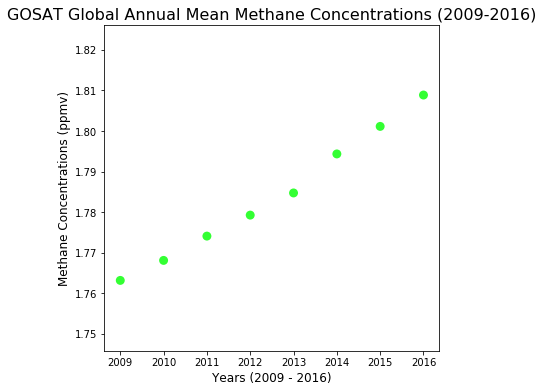

In [775]:
plt.close()
plt.figure(figsize=(6, 6))

#del global_annual_mean[2017]
global_annual_mean # no 2017
global_annual_means = global_annual_mean.values()
plot_annual_mean(plt, all_years[:-1], global_annual_mean.values(), 'GOSAT Global Annual Mean Methane Concentrations (2009-2016)'
                , 'Years (2009 - 2016)')
plt.savefig('gosat-yearly-average(2009-2016.png')

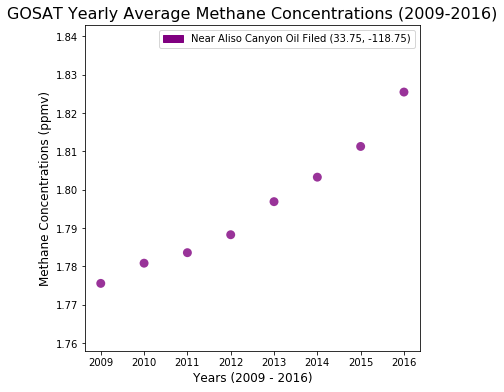

In [755]:
xs = [y[0] for y in aliso_yearly_trend]
ys = [y[1] for y in aliso_yearly_trend]

plt.figure(figsize=(6, 6))
plt.scatter(xs, ys, s=80, c='Purple', edgecolor='', alpha=0.8)
label_axes(plt, 'Years (2009 - 2016)', 'Methane Concentrations (ppmv)', 'GOSAT Yearly Average Methane Concentrations (2009-2016)')
#plt.savefig('gosat-yearly-average-aliso.png')

# reference
red_patch = mpatches.Patch(color='Purple', label='Near Aliso Canyon Oil Filed (33.75, -118.75)')
plt.legend(handles=[red_patch])
plt.show()

In [772]:
aliso_annual_means = ys

In [790]:
def plot_annual_anomaly(_plt, _xs, _ys, _title, _xlab, addpatch=False):
    ylab = 'Methane Concentrations Anomaly (ppmv)'
    _plt.scatter(_xs, _ys, s=80, c='lightsalmon', edgecolor='', alpha=0.8)
    label_axes(_plt, _xlab, ylab, _title)
    if addpatch:
        patch = mpatches.Patch(color='lightsalmon', label='Near Aliso Canyon Oil Filed (33.75, -118.75)')
        plt.legend(handles=[patch])
    _plt.show()

aliso_annual_anomaly = [aliso_mean - global_mean for aliso_mean, global_mean in zip(aliso_annual_means, global_annual_means)]

In [791]:
aliso_annual_anomaly

[0.012443219462171529,
 0.012771445816634364,
 0.009519677434088436,
 0.0090212796154345298,
 0.012173498706945063,
 0.0089337689824451338,
 0.010148038391070147,
 0.016591384510222795]

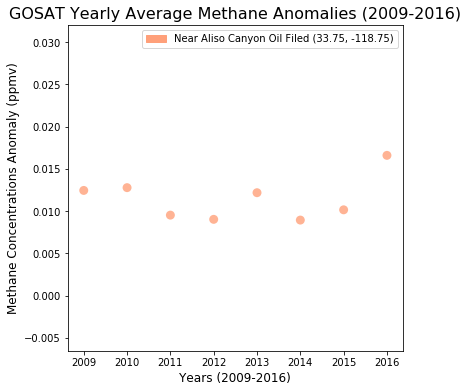

In [793]:
plt.close()
plt.figure(figsize=(6, 6))

plot_annual_anomaly(plt, all_years[:-1], aliso_annual_anomaly, 
                 'GOSAT Yearly Average Methane Anomalies (2009-2016)', 'Years (2009-2016)', addpatch=True)
plt.show()
plt.savefig('gosat-year-average-methane-anomaly-2009-2016')